# <center>Brain Tumor Detection</center>

## Overview: 
A brain tumor is an abnormal growth of cells in the brain, which can be either non-cancerous or cancerous. These tumors may originate within the brain or spread from other parts of the body. They can disrupt normal brain functions, leading to symptoms such as headaches, seizures, cognitive impairments, and motor deficits. Treatment options include surgery, radiation therapy, chemotherapy, or a combination, depending on the tumor type, location, and stage. Therefore Early detection is crucial for effective management.

Types of Brain Tumors We've taken for Detection:
* Pituatory Tumor
* Glioma Tumor
* Meningioma Tumor

## Dataset Information:

Brain MRI Dataset: [Kaggle - Brain Tumor Detection](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

This dataset of size 164MB contains 7023 images of human brain MRI images which are classified into 4 classes: glioma, meningioma, no tumor and, pituitary.

### Training Data:

   * Glioma Tumor: 1321 Images
   * Meningioma Tumor: 1339 Images
   * No Tumor: 1595 Images
   * Pituitary Tumor: 1457 Images
   
### Testing Data:

   * Glioma Tumor: 300 Images
   * Meningioma Tumor: 306 Images
   * No Tumor: 405 Images
   * Pituitary Tumor: 300 Images

# 1. Import needed libraries

In [41]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [42]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [43]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [44]:
tr_df = train_df('/content/drive/MyDrive/Academic/Datasets/BrainMRI/Training')

In [45]:
tr_df["Class Path"][0]

'/content/drive/MyDrive/Academic/Datasets/BrainMRI/Training/pituitary/Tr-pi_1200.jpg'

In [46]:
ts_df = test_df('/content/drive/MyDrive/Academic/Datasets/BrainMRI/Testing')

In [47]:
ts_df

,Class Path,Class
0,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma
1,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma
2,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma
3,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma
4,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma
...,...,...
1306,/content/drive/MyDrive/Academic/Datasets/Brain...,pituitary
1307,/content/drive/MyDrive/Academic/Datasets/Brain...,pituitary
1308,/content/drive/MyDrive/Academic/Datasets/Brain...,pituitary
1309,/content/drive/MyDrive/Academic/Datasets/Brain...,pituitary


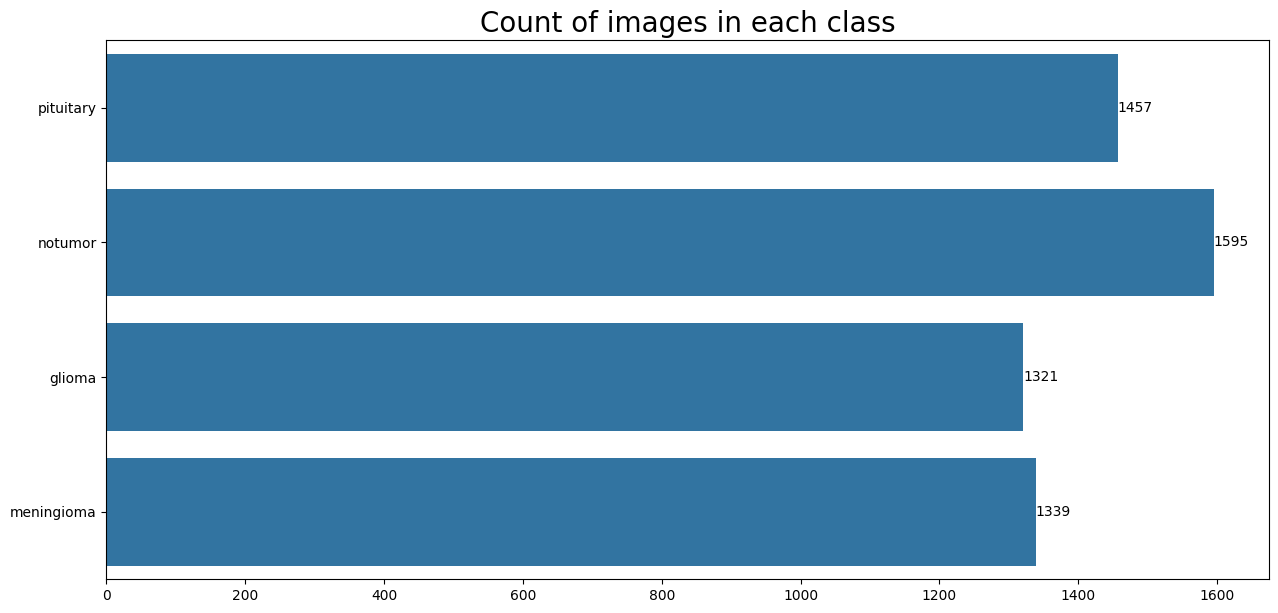

In [48]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

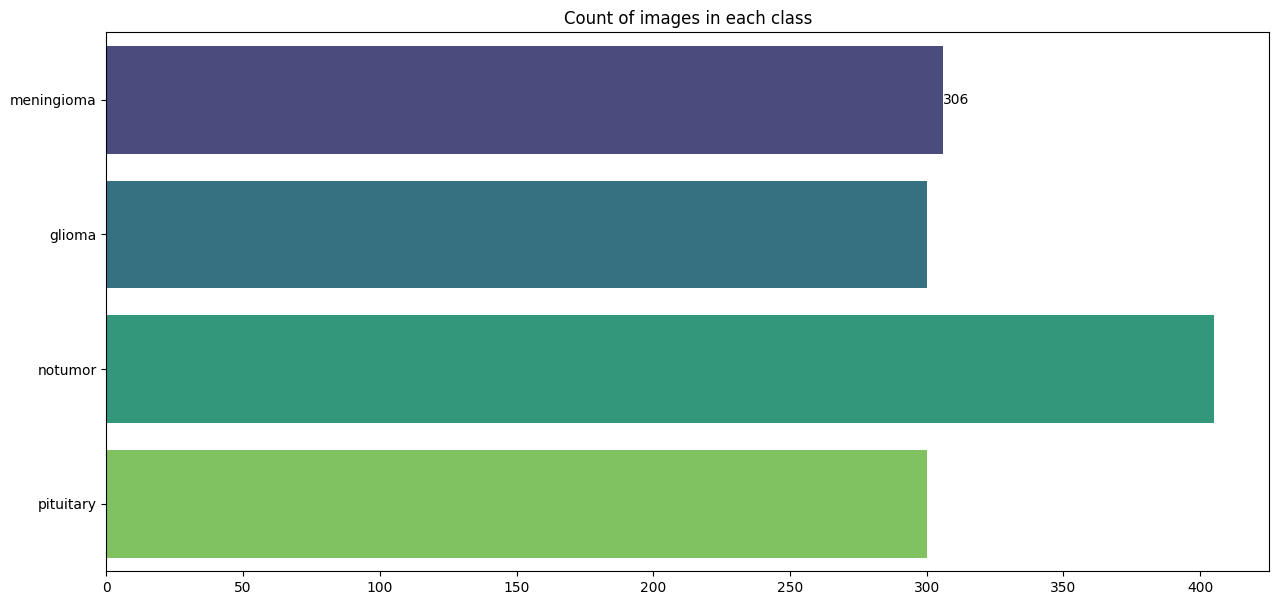

In [49]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [50]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [51]:
valid_df

,Class Path,Class
592,/content/drive/MyDrive/Academic/Datasets/Brain...,glioma
18,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma
1072,/content/drive/MyDrive/Academic/Datasets/Brain...,pituitary
73,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma
415,/content/drive/MyDrive/Academic/Datasets/Brain...,glioma
...,...,...
365,/content/drive/MyDrive/Academic/Datasets/Brain...,glioma
860,/content/drive/MyDrive/Academic/Datasets/Brain...,notumor
579,/content/drive/MyDrive/Academic/Datasets/Brain...,glioma
194,/content/drive/MyDrive/Academic/Datasets/Brain...,meningioma


## 2.3 Data preprocessing

In [52]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

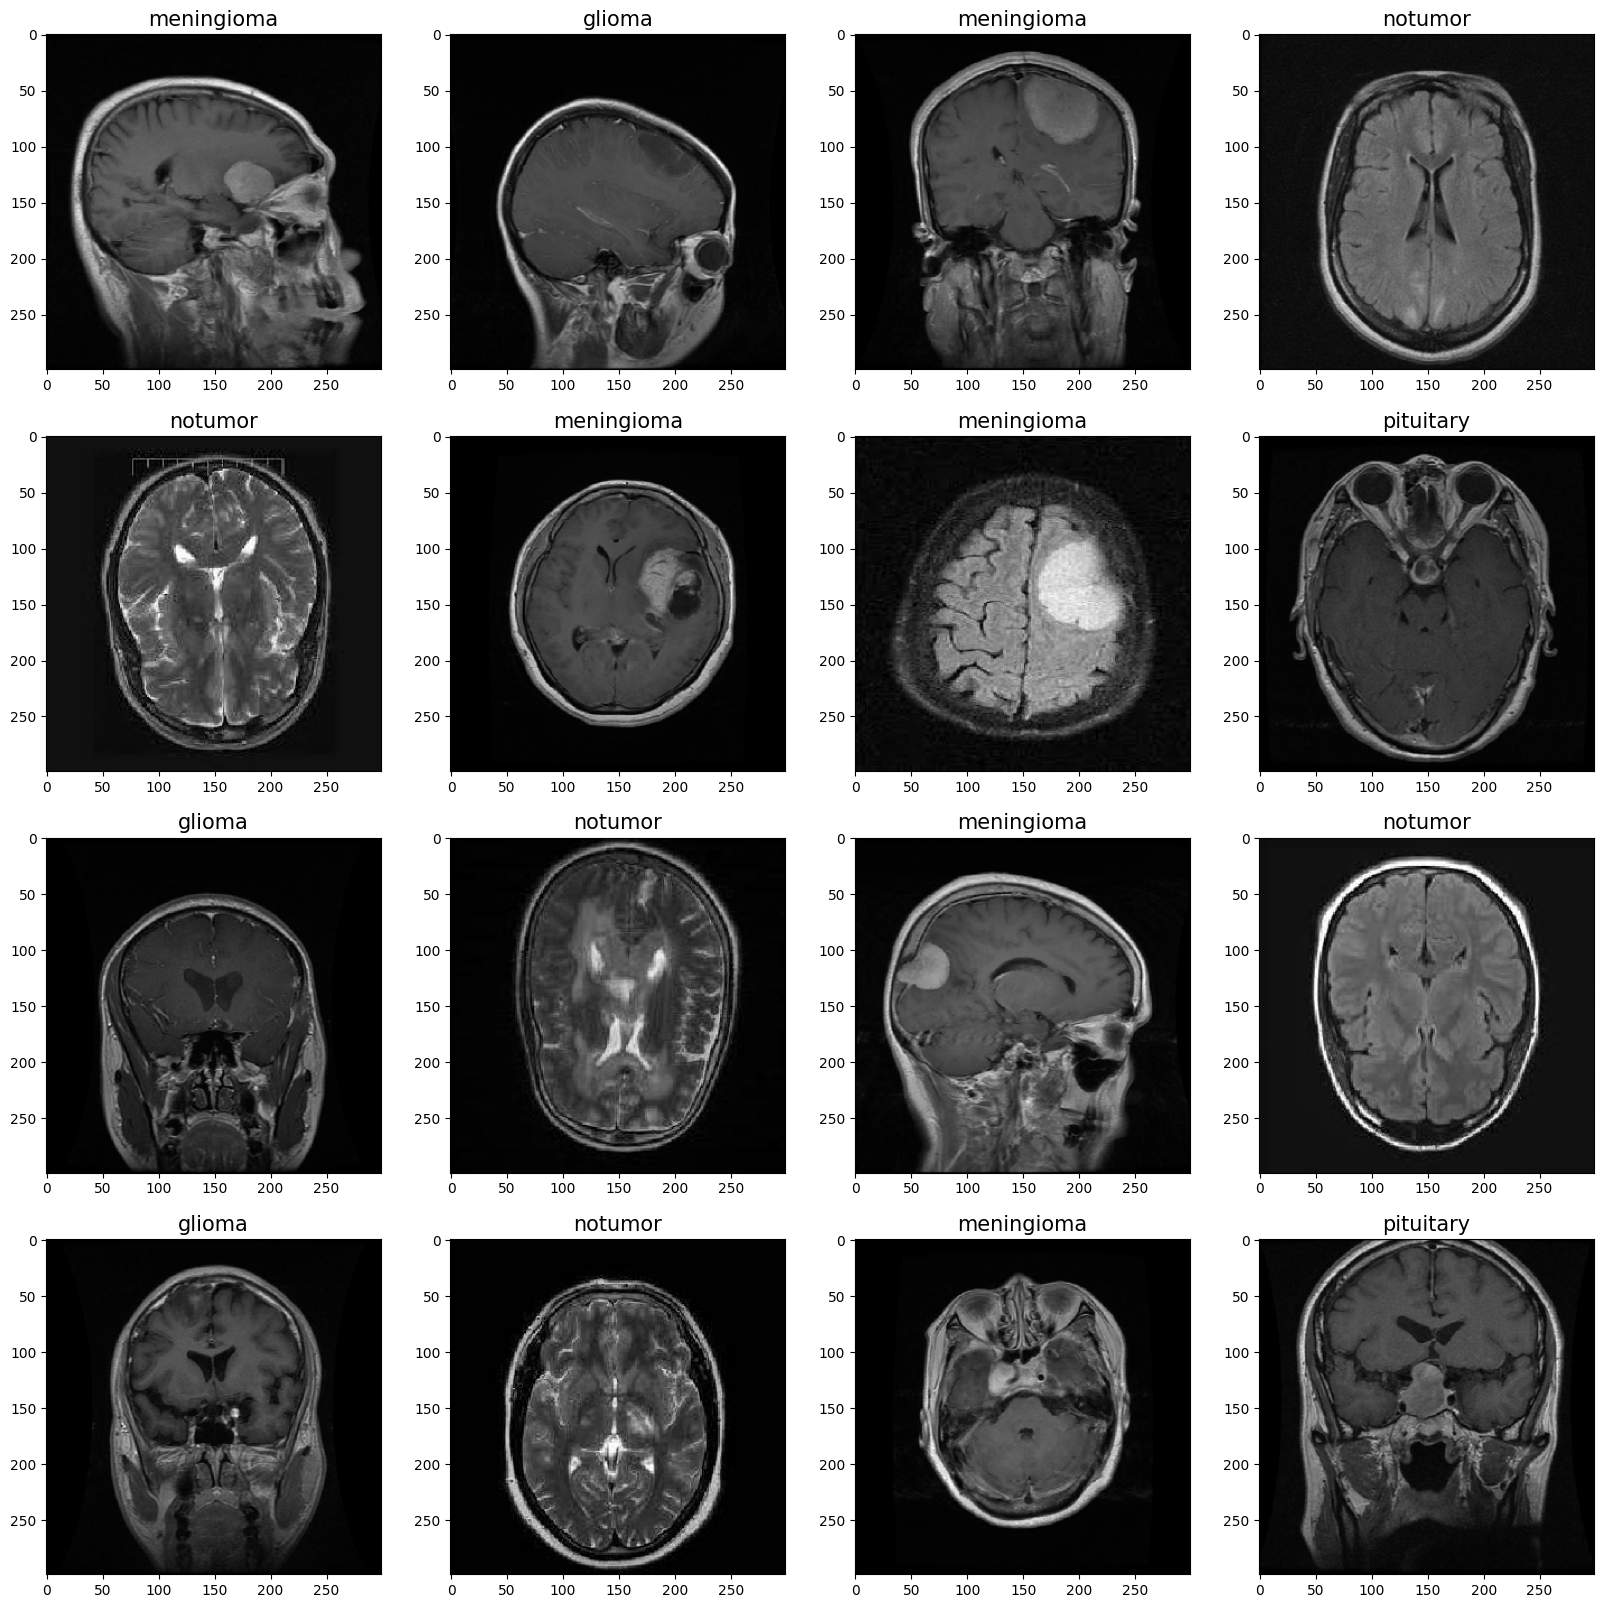

In [53]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [54]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

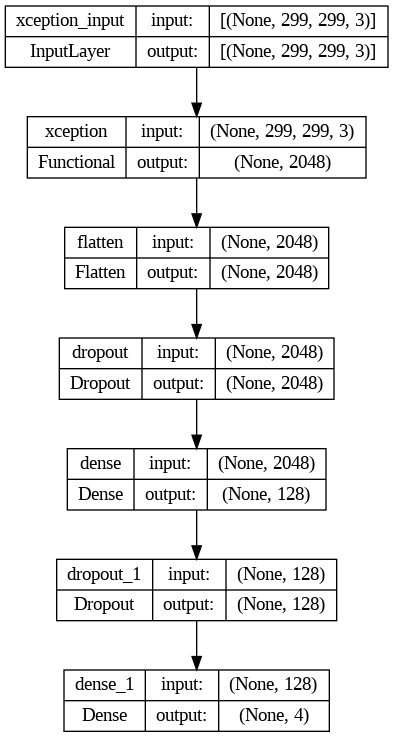

In [55]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [56]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 [==============================] - 1128s 6s/step - loss: 0.3623 - accuracy: 0.8739 - precision: 0.9177 - recall: 0.8333 - val_loss: 0.2339 - val_accuracy: 0.9191 - val_precision: 0.9314 - val_recall: 0.9115
Epoch 2/10
179/179 [==============================] - 158s 881ms/step - loss: 0.0656 - accuracy: 0.9792 - precision: 0.9817 - recall: 0.9776 - val_loss: 0.0764 - val_accuracy: 0.9740 - val_precision: 0.9739 - val_recall: 0.9679
Epoch 3/10
179/179 [==============================] - 159s 887ms/step - loss: 0.0210 - accuracy: 0.9925 - precision: 0.9932 - recall: 0.9923 - val_loss: 0.0415 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878
Epoch 4/10
179/179 [==============================] - 159s 887ms/step - loss: 0.0202 - accuracy: 0.9933 - precision: 0.9935 - recall: 0.9933 - val_loss: 0.0525 - val_accuracy: 0.9863 - val_precision: 0.9863 - val_recall: 0.9863
Epoch 5/10
179/179 [==============================] - 160s 894ms/step - loss: 0.0268 - acc

In [57]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

## 4.1 Visualize model performance

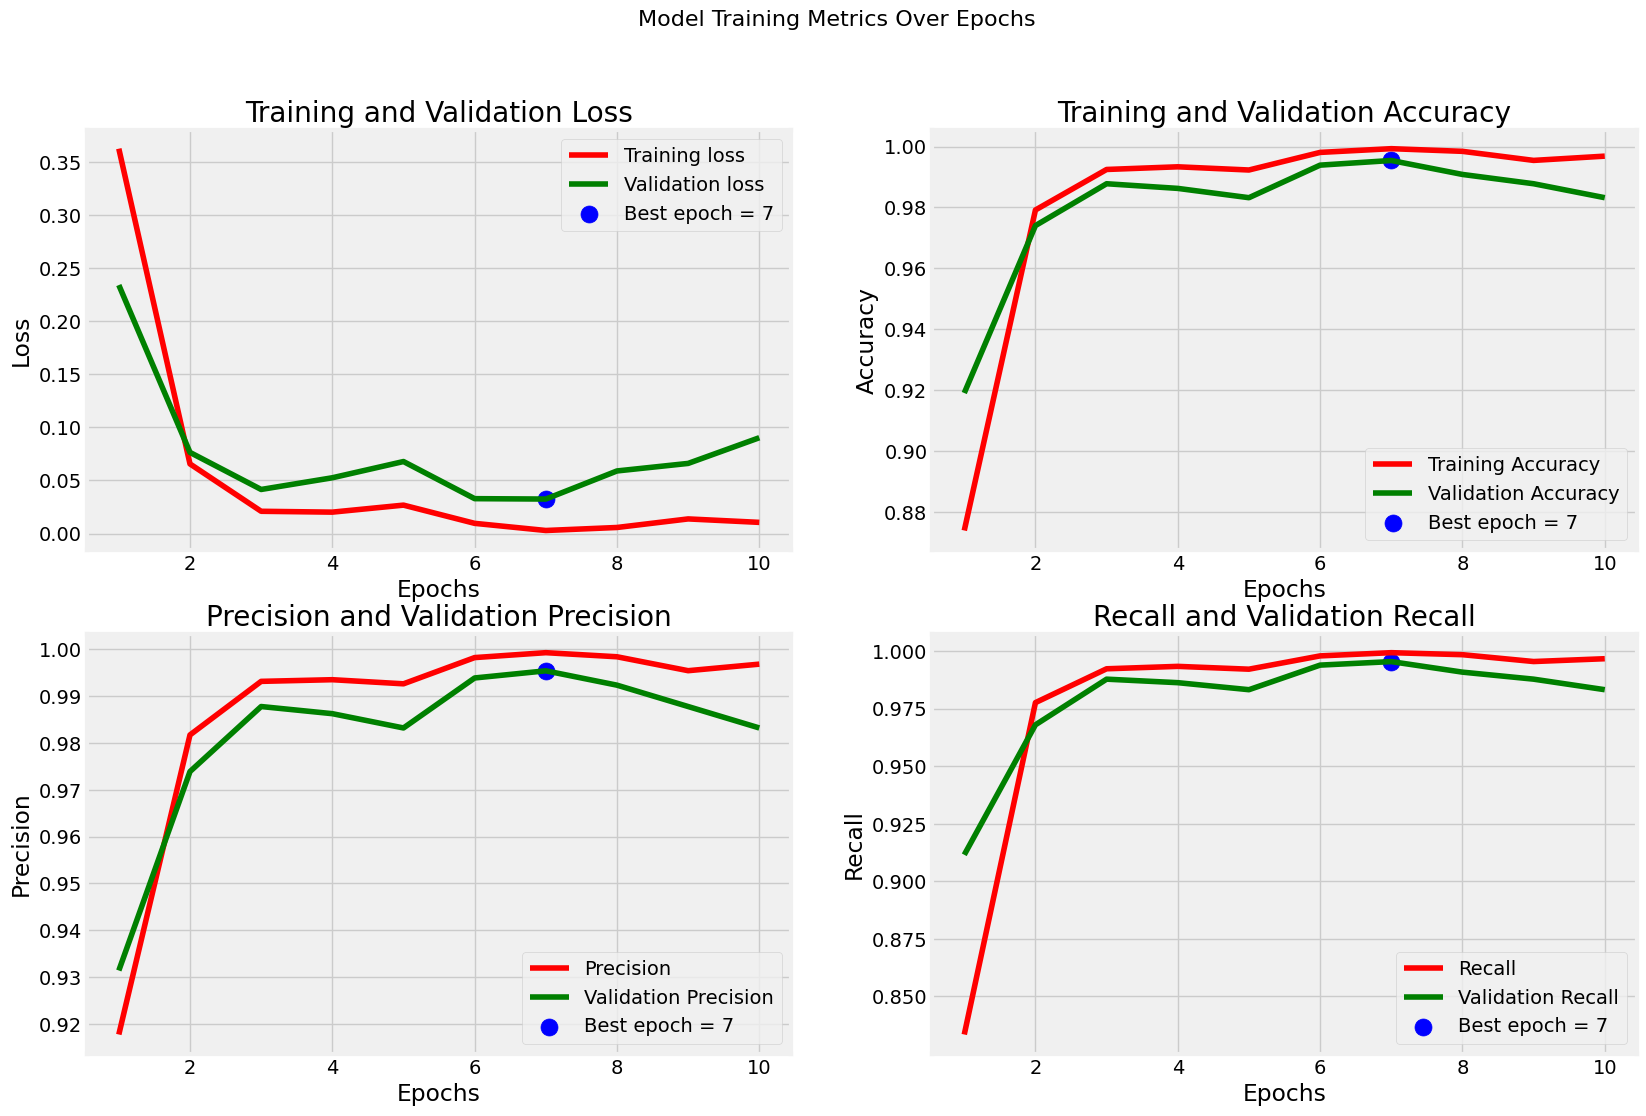

In [58]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [59]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


41/41 [==============================] - 99s 2s/step - loss: 0.0603 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848
Train Loss: 0.0267
Train Accuracy: 99.42%
--------------------
Validation Loss: 0.0903
Validation Accuracy: 98.47%
--------------------
Test Loss: 0.0603
Test Accuracy: 98.48%


In [60]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 7s 141ms/step


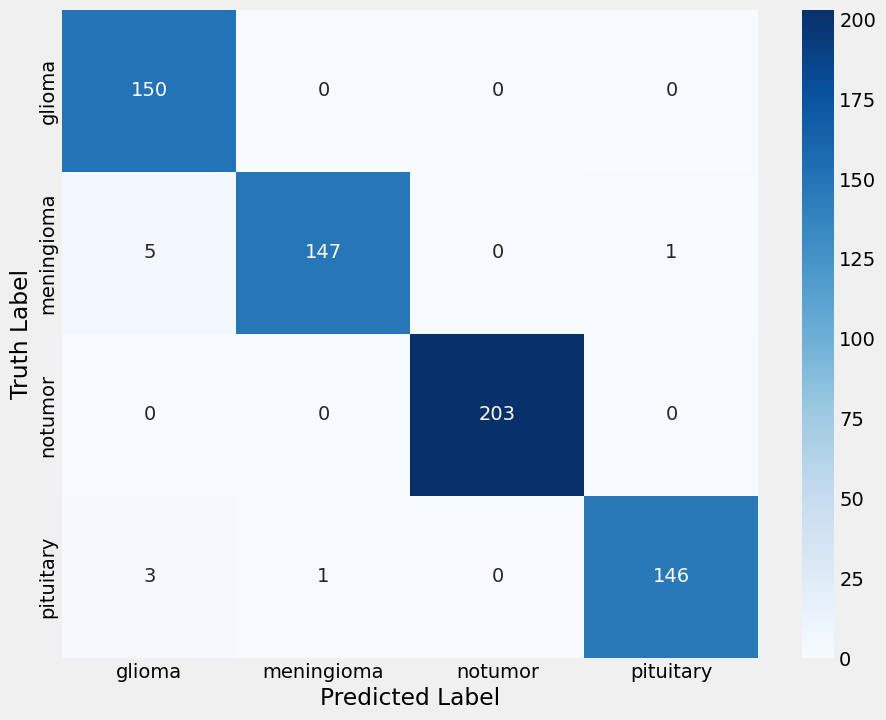

In [61]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [62]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       150
           1       0.99      0.96      0.98       153
           2       1.00      1.00      1.00       203
           3       0.99      0.97      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.99      0.98      0.98       656



## 5.2 Testing

In [63]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 3s 3s/step


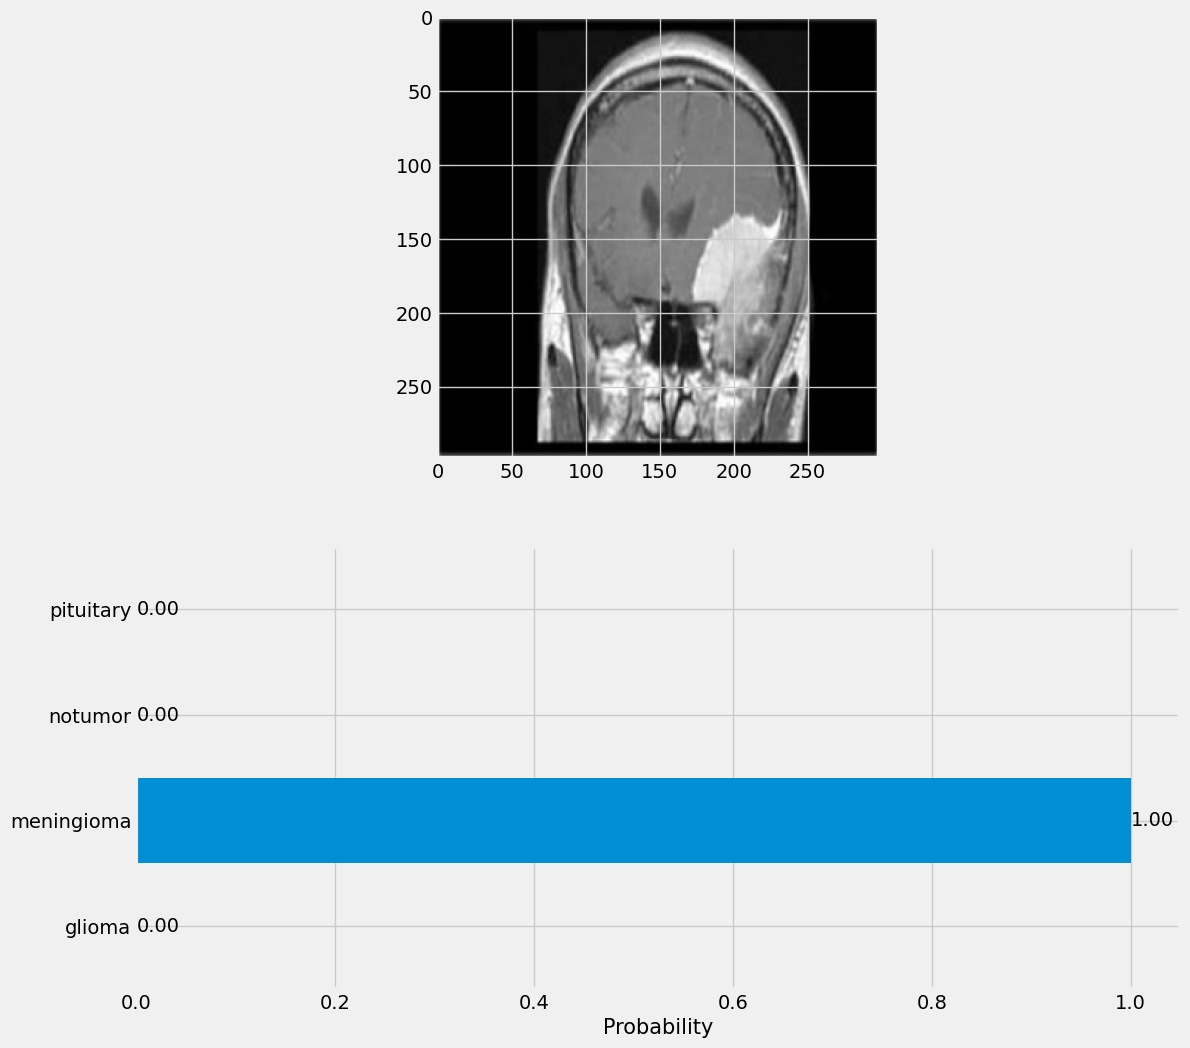

In [65]:
predict('/content/drive/MyDrive/Academic/Datasets/BrainMRI/Testing/meningioma/Te-meTr_0000.jpg')